# The role of data scientists in building fairer machine learning 
## AIF360 Case study: Predictive risk assessment tool German Credit data set
Developed by Jurriaan Parie, Data scientist IBM Northern Europe. For questions please reach out to Jurriaan.Parie@ibm.com.

### Load libraries and helper code

In [1]:
import sys
sys.path.insert(0, "../")  

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

# Dataset
from german_dataset import GermanDataset

# Helper functions
from helper_functions import default_preprocessing, test, plot, plot_acc_fair

# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric

# Scalers
from sklearn.preprocessing import StandardScaler

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

np.random.seed(0)

### Loading data

In [2]:
gd = GermanDataset(
    
    # default pre-processing
    custom_preprocessing=default_preprocessing
)

Convert to pandas data frame.

In [3]:
df_gd = gd.convert_to_dataframe()[0]
df_gd.head()

,month,credit_amount,investment_as_income_percentage,residence_since,age,number_of_credits,people_liable_for,status=A11,status=A12,status=A13,...,housing=A153,skill_level=A171,skill_level=A172,skill_level=A173,skill_level=A174,telephone=A191,telephone=A192,foreign_worker=A201,foreign_worker=A202,credit
0,6.0,1169.0,4.0,4.0,67.0,2.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1,48.0,5951.0,2.0,2.0,22.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
2,12.0,2096.0,2.0,3.0,49.0,1.0,2.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,42.0,7882.0,2.0,4.0,45.0,1.0,2.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,24.0,4870.0,3.0,4.0,53.0,2.0,2.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0


### Explanatory data analysis – Percentage of defaults per age group

In [55]:
# create bins and labels
bins = [18,25,35,45,55,65,75]
labels = ["%s-%s" %(bins[idx-1],bins[idx]) for idx in range(1,len(bins))]

# bin age colum
b = pd.cut(df_gd['age'], bins=bins, labels=labels, include_lowest=True)

# groupby age and credit column
df_grouped = df_gd.groupby(['credit', b]).size().unstack(fill_value=0).stack().reset_index(name='count')
df_grouped = df_grouped.groupby(['age','credit']).sum()
df_grouped

count
age   credit       
18-25 0.0       110
      1.0        80
25-35 0.0       280
      1.0       118
35-45 0.0       171
      1.0        55
45-55 0.0        87
      1.0        28
55-65 0.0        39
      1.0        14
65-75 0.0        13
      1.0         5

In [86]:
bin_default_dict = {}
bin_non_default_dict = {}

# iterate through age groups to compute default percentage
for label in labels:
    
    # number of defaulting applicants 
    n_default = df_grouped.loc[(label, 1.0)]['count']
    n_non_default = df_grouped.loc[(label, 0.0)]['count']
    
    # append to dictionary
    bin_default_dict["%s" %label] = str('{0:.0f}'.format((n_default/(n_default+n_non_default))*100)) + "%"
    bin_non_default_dict["%s" %label] = str('{0:.0f}'.format((n_non_default/(n_default+n_non_default))*100)) + "%"

bin_default_dict

{'18-25': '42%',
 '25-35': '30%',
 '35-45': '24%',
 '45-55': '24%',
 '55-65': '26%',
 '65-75': '28%'}

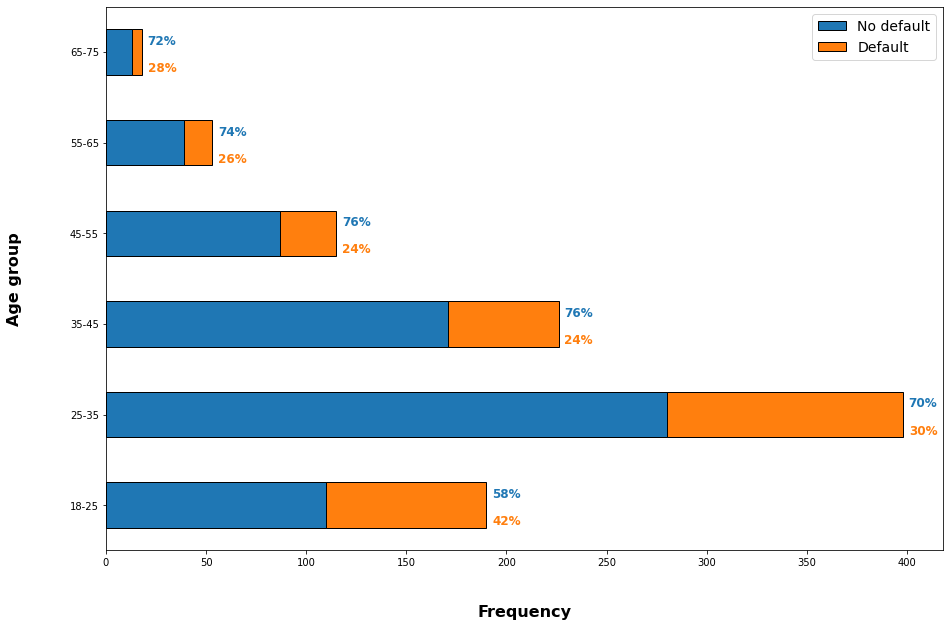

In [88]:
# plot
fig, ax = plt.subplots(figsize=(15,10))
df_grouped.unstack().plot(kind='barh', stacked=True, ax=ax, edgecolor='k')

# x-axis
ax.set_xlabel("Frequency", fontsize=16, fontweight='bold')
ax.xaxis.set_label_coords(0.5, -0.1)

# y-axis
ax.set_ylabel("Age group", fontsize=16, fontweight='bold')
ax.yaxis.set_label_coords(-0.1, 0.5)

# iterate through labels
for i in range(0,6):
    label = labels[i]
    x_coord = df_grouped.loc[label]['count'].sum()
    y_coord = i
    
    # annotate text
    plt.text(x_coord+10, y_coord+0.05, bin_non_default_dict[label], ha="center", va="bottom", color="tab:blue", fontsize=12, fontweight="bold")
    plt.text(x_coord+10, y_coord-0.25, bin_default_dict[label], ha="center", va="bottom", color="tab:orange", fontsize=12, fontweight="bold")

# legend
ax.legend(['No default','Default'], fontsize=14)
    
plt.show()

### Initialize (un)priviliged groups and split original data set

In [2]:
# age as protected attribute
prot_attr = 'age'
age_level = 25

# (un)priviliged groups
privileged_groups = [{'age': 1}]    # applicants wiht age ≥ age_level
unprivileged_groups = [{'age': 0}]  # applicants with age < age_level

# pre-processing data set AIF360
gd = GermanDataset(
    
    # specify protected attribute
    protected_attribute_names=[prot_attr],

    # initialize priviliged class            
    privileged_classes=[lambda x: x >= age_level],

    # default pre-processing
    custom_preprocessing=default_preprocessing
)

# split data
gd_train, gd_val, gd_test = gd.split([0.5, 0.8], shuffle=True)

### Table 1 – Number of (un)favourable and (un)priviliged applicants

In [15]:
df_gd_train = gd_train.convert_to_dataframe()[0]
df_gd_train.head()

,month,credit_amount,investment_as_income_percentage,residence_since,age,number_of_credits,people_liable_for,status=A11,status=A12,status=A13,...,housing=A153,skill_level=A171,skill_level=A172,skill_level=A173,skill_level=A174,telephone=A191,telephone=A192,foreign_worker=A201,foreign_worker=A202,credit
993,36.0,3959.0,4.0,3.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
859,9.0,3577.0,1.0,2.0,1.0,1.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
298,18.0,2515.0,3.0,4.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
553,12.0,1995.0,4.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
672,60.0,10366.0,2.0,4.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0


In [16]:
## unfavourable and priviliged 
a = df_gd_train[(df_gd_train['credit']==1.0) & (df_gd_train['age']==1.0)].shape[0]
print(a) 

## favourable and priviliged 
b = df_gd_train[(df_gd_train['credit']==0.0) & (df_gd_train['age']==1.0)].shape[0]
print(b) 

## unfavourable and unpriviliged 
c = df_gd_train[(df_gd_train['credit']==1.0) & (df_gd_train['age']==0.0)].shape[0]
print(c) 

## favourable and unpriviliged 
d = df_gd_train[(df_gd_train['credit']==0.0) & (df_gd_train['age']==0.0)].shape[0]
print(d) 

print("Total: " + str(a+b+c+d))

p1 = b/(a+b)
p2 = d/(c+d)

p3 = a/(a+b)
p4 = c/(c+d)

print("Stat. diff. par.: " + str(p1 - p2))
print("Disprate impact: " + str(p2/p1))

117
305
33
45
Total: 500
Stat. diff. par.: 0.14582573824279987
Disprate impact: 0.798234552332913


### Compute fairness metrics based on observed favorable outcomes in original data set

In [17]:
# compute metrics
metric_gd_train = BinaryLabelDatasetMetric(gd_train, 
                                           unprivileged_groups=unprivileged_groups,
                                           privileged_groups=privileged_groups)

# statistical parity difference
print("Statistical parity difference = %f" %metric_gd_train.statistical_parity_difference())

# disparate impact
print("Disparate impact = %f" %metric_gd_train.disparate_impact())

Statistical parity difference = -0.145826
Disparate impact = 0.798235


### Initializing ML pipeline

In [18]:
# initialize pipeline
model = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='liblinear', random_state=1))

# model parameters
fit_params = {'logisticregression__sample_weight': gd_train.instance_weights}

# fit model
lr_orig = model.fit(gd_train.features, gd_train.labels.ravel(), **fit_params)

### Apply sequence of thresholds on validation set

In [19]:
# specify candidate threshold
thresh_arr = np.linspace(0.5, 1, 50)

# compute metrics
val_metrics = test(dataset=gd_val,
                   model=lr_orig,
                   thresh_arr=thresh_arr,
                   unprivileged_groups=unprivileged_groups,
                   privileged_groups=privileged_groups)

### Plot model accuracy as a function of classification threshold on the validation set

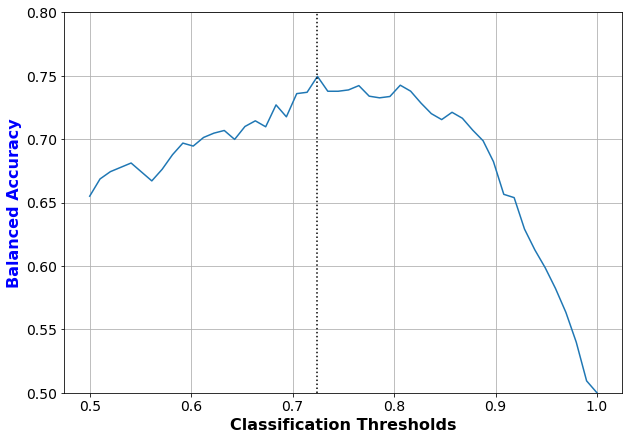

In [8]:
# threshold with highest balanced accuracy
lr_orig_best_ind = np.argmax(val_metrics['bal_acc'])

# plot function
plot(thresh_arr,                    # threshold
     'Classification Thresholds',   # x-asis name
     val_metrics['bal_acc'],        # variable left y-axis
     'Balanced Accuracy',           # name left y-axis
     [0.50,0.80],                   # left y-axis limits 
)

### Plot model accuracy and fairness metrics as a function of classification threshold on the validation set

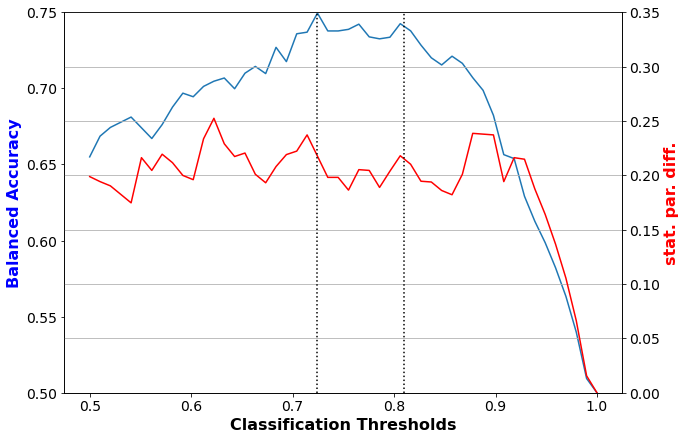

In [20]:
# plot function
plot_acc_fair(thresh_arr,                    # threshold
              'Classification Thresholds',   # x-asis name
              val_metrics['bal_acc'],        # variable left y-axis
              'Balanced Accuracy',           # name left y-axis
              val_metrics['stat_par_diff'],  # variable right y-axis
              'stat. par. diff.',            # name right y-axis
              [0.50,0.75],                   # left y-axis limits 
              [0,0.35],                      # right y-axis limits 
              thres = 0.81)                  # comparative threshold

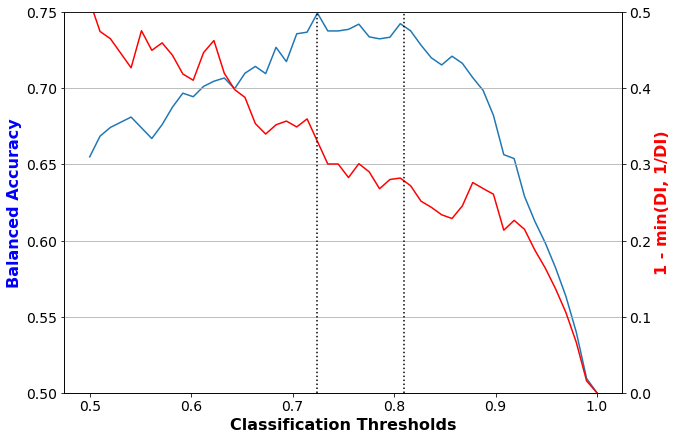

In [22]:
# calculate adjusted disparate impact measure 
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)

# plot function
plot_acc_fair(thresh_arr,           # threshold
     'Classification Thresholds',   # x-asis name
     val_metrics['bal_acc'],        # variable left y-axis
     'Balanced Accuracy',           # name left y-axis
     disp_imp_err,                  # variable right y-axis
     '1 - min(DI, 1/DI)',           # name right y-axis
     [0.50,0.75],                   # left y-axis limits 
     [0,0.5],                       # right y-axis limits 
     thres = 0.81)                  # comparative threshold